## Exploratory Data Analysis

### Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
pd.options.display.max_columns = None

The optimized dataset after data wrangling was stored as a pickled file. 

In [2]:
df = pd.read_pickle('project_donation_optimized.pkl')

### Exploratory Data Analysis

The exploratory data analysis provides an in-depth analysis of the DonorsChoose dataset. It provides insights from different perspectives including donations, projects, and how the userbase grew over time. To make the analysis more relevant to the US market, we will only look at donations that happened in US. 

In [4]:
## get US dataset by mapping the states
xl = pd.ExcelFile('state_long_lat.xlsx')
lon_lat_map = xl.parse('state_long_lat')
us_states = lon_lat_map['State_Short']
df_us = df[(df['donor_state'].notnull()) & (df['donor_state'].isin(us_states))]

### Donors & Donations

To start with, we will run some general numbers from the dataset including total number of donors and donations to see how many donors are actively using the website to make contributions. 

In [71]:
## total number of donors
donor_number = df_us['_donor_acctid'].nunique()
total_donation = df_us['donation_total'].sum()
print("As of October 2016, there are " + 
      str(donor_number) + 
      """ registered donors on DonorsChoose, who have made a total contribution of """ + 
      str(total_donation) + " dollars.")

As of October 2016, there are 1786756 registered donors on DonorsChoose, who have made a total contribution of 362873020.0 dollars.


Next, I would love to see among all the users, how many are frequent versus single-time donors. 

In [6]:
donation_count = df_us.groupby('_donor_acctid').size().to_frame().reset_index()
donation_count.columns = ['donor_id', 'donation_count']
#donation_count.head()
donation_freq = donation_count['donation_count'].value_counts(ascending=False).to_frame().reset_index()
donation_freq.columns = ['donation_frequency', 'count']
donation_freq.head()

,donation_frequency,count
0,1,1318268
1,2,250701
2,3,85637
3,4,40662
4,5,23093


Out of the 1786756 donors, majority (1318268) of them have only donated once, and only 26% are frequent donors. 

In [8]:
big_donor = donation_count[donation_count['donation_count']>=100]
big_donor['donor_id'].count()

1997

There are 1997 donors who have donated more than 100 times. I will categorize them into the big_donor category for future analysis.

### Donation Distribution

It is interesting to see how different states are using the service and where the donations are concentrated. This can be reflected in both the number of donations and total donation amount in each state. 

In [9]:
donor_state_count = df_us.groupby(df_us['donor_state'].astype('object')).size().sort_values(ascending=False)
max_donor_state = donor_state_count.head(10)
min_donor_state = donor_state_count.tail(10)

In [13]:
state_don_amt = df_us.groupby(df_us['donor_state'].astype('object'))['donation_total'].sum().sort_values(ascending=False)
max_state_amt = state_don_amt.head(10)
min_state_amt = state_don_amt.tail(10)

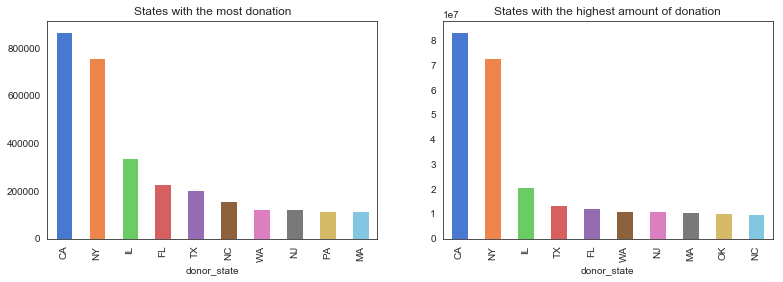

In [77]:
### states with the most donation
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
sns.set_style('white')
sns.set_palette('muted')
ax0.set_title('States with the most donation')
ax1.set_title('States with the highest amount of donation')
max_donor_state.plot.bar(ax=ax0)
max_state_amt.plot.bar(ax=ax1)

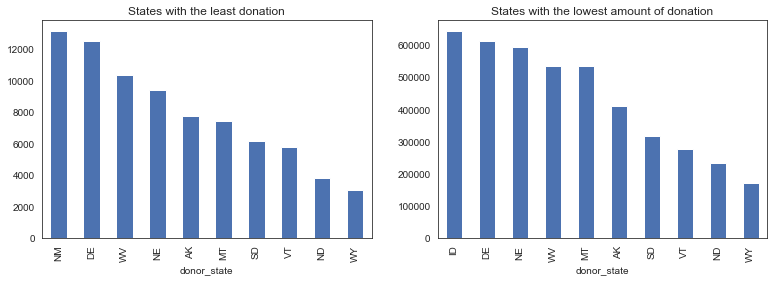

In [78]:
### states with the least donation
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
sns.set_style('white')
ax0.set_title('States with the least donation')
ax1.set_title('States with the lowest amount of donation')
min_donor_state.plot.bar(ax=ax0, color='b')
min_state_amt.plot.bar(ax=ax1, color='b')

Lastly, let's find out the cities with the most number of donations and store them as a list of big cities.  

In [79]:
donor_city_count = df_us.groupby(df_us['donor_city'].astype('object')).size().sort_values(ascending=False)
max_donor_city = donor_city_count.head(10)
big_city = max_donor_city.index.tolist()

### Projects

In [17]:
print(df_us['_projectid'].nunique())
print(df_us['date_posted'].max())

924255
2016-10-11 00:00:00


As of October 2016, there are in total 924,255 projects posted on the website. In order to see how the number of projects has grown over time, we will break the numbers down into different years. We also notice that for the projects posted on the platform, they can either be completed or expired without enough donation. We would also like to see the trends in fully-funded projects. 

In [18]:
df_us['project_year'] = df_us['date_posted'].dt.year
df_us['complete_year'] = df_us['date_completed'].dt.year

C:\Users\Leo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Leo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
### projects posted over time
project_over_time = df_us.groupby('project_year')['_projectid'].nunique()
completed_projects = df_us[df_us['funding_status']=='completed']
completed_over_time = completed_projects.groupby('complete_year')['_projectid'].nunique()

Text(0.5, 1.0, 'Number of total and completed projects')

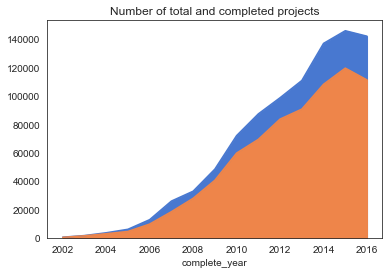

In [85]:
sns.set_style('white')
fig, ax = plt.subplots()
project_over_time.plot.area(ax=ax)
completed_over_time.plot.area(ax=ax)
ax.set_title('Number of total and completed projects')

We can see that the project flow started to pick up in a fast pace starting around year 2006. A quick research on the company's Wikipedia page unfolds that the organization has been given Charity Navigator's highest rating every year since 2005. This corresponds to the high growth path revealed in the chart.  

With the drastic growth in number of posted projects, it would important to keep the turnaround. I am curious to know whether it's taking longer or shorter for each project to be completed. 

In [21]:
### average time for projects to be completed
df_complete = df_us[df_us['funding_status']=='completed']
df_complete['days_to_complete'] = (df_complete['date_completed']-df_complete['date_posted']).dt.days
df_complete= df_complete[['_projectid', 'project_year', 'days_to_complete']].drop_duplicates()

C:\Users\Leo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [80]:
#df_complete.head()
df_complete_nan = df_complete.dropna()

In [81]:
average_completion_days = df_complete.groupby('project_year')['days_to_complete'].mean()
#average_completion_days.values

C:\Users\Leo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


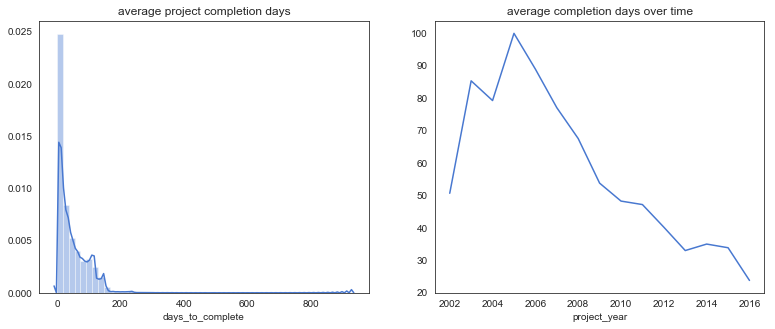

In [88]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
sns.set_style('white')
ax0.set_title('average project completion days')
ax1.set_title('average completion days over time')
sns.distplot(df_complete_nan['days_to_complete'], ax = ax0)
sns.lineplot(x=average_completion_days.index, y=average_completion_days.values, ax = ax1)

Majority of the projects are fully-donated within 100 days, and the turnaround keeps decreasing with more and more people start using the platform. The projects that are posted recently were completed within around a month. 

Now we have an idea of the project volume, let's take a look at the donation amount associated with each project. We will identify the projects with the most donation count, highest donation amount, and the average donation of all the completed projects. 

In [25]:
## project donation size
total_donation_per_project = completed_projects.groupby('_projectid')['donation_total'].sum()
total_donation_per_project = total_donation_per_project.sort_values(ascending=False)
average_donation = total_donation_per_project.mean()
average_donation

457.025634765625

In [26]:
## max donation size
print('highest donation amount: ' + str(total_donation_per_project.max()))
print('max number of donation: ' + str(completed_projects['num_donors'].max()))

highest donation amount: 186951.77
max number of donation: 848


In [27]:
print(total_donation_per_project.sort_values(ascending=False).head(1))

_projectid
bbbc6cccccd3c1bc8c44ec494bb6cf23    186951.765625
Name: donation_total, dtype: float32


In [28]:
completed_projects[completed_projects['_projectid']=='bbbc6cccccd3c1bc8c44ec494bb6cf23'].head(2)

,_donationid,_projectid,_donor_acctid,donor_city,donor_state,is_teacher_acct,donation_timestamp,donation_to_project,donation_optional_support,donation_total,payment_method,is_teacher_referred,thank_you_packet_mailed,_teacher_acctid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,school_county,teacher_prefix,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,total_donations,num_donors,eligible_double_your_impact_match,eligible_almost_home_match,funding_status,date_posted,date_completed,date_thank_you_packet_mailed,date_expiration,project_year,complete_year
254134,01d72050cfc5714eb5f9bde7f2a1e2f0,bbbc6cccccd3c1bc8c44ec494bb6cf23,4242433cbedd23bf0f4f3ff22eb17ccc,NaN,OR,0,2015-12-03 14:04:45.633,425.00,75.00,500.0,paypal,0,f,ba835ad62be9d5f38b2e54a8edbf83fb,NaN,40.839062,-73.900124,New York City,NY,10457.0,urban,New York Dept Of Education,Bronx,Mr.,Gym & Fitness,Health & Sports,NaN,NaN,Supplies,highest poverty,Grades 3-5,217377.015625,255737.671875,999.0,249253.3125,313,t,f,completed,2015-08-28,2015-12-28,NaT,2016-01-29,2015,2015.0
254136,01dd0a7985b986793d9d6ae6204023b0,bbbc6cccccd3c1bc8c44ec494bb6cf23,0e210f62f3f0cb27598664a7f0116b09,NaN,NY,0,2015-12-01 23:38:29.281,21.25,3.75,25.0,creditcard,0,f,ba835ad62be9d5f38b2e54a8edbf83fb,NaN,40.839062,-73.900124,New York City,NY,10457.0,urban,New York Dept Of Education,Bronx,Mr.,Gym & Fitness,Health & Sports,NaN,NaN,Supplies,highest poverty,Grades 3-5,217377.015625,255737.671875,999.0,249253.3125,313,t,f,completed,2015-08-28,2015-12-28,NaT,2016-01-29,2015,2015.0


In [29]:
completed_projects[completed_projects['num_donors']==848]
completed_projects[completed_projects['_projectid']=='c34218abf3fecd36be01305d67ed7fbb'].head(2)

,_donationid,_projectid,_donor_acctid,donor_city,donor_state,is_teacher_acct,donation_timestamp,donation_to_project,donation_optional_support,donation_total,payment_method,is_teacher_referred,thank_you_packet_mailed,_teacher_acctid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,school_county,teacher_prefix,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,total_donations,num_donors,eligible_double_your_impact_match,eligible_almost_home_match,funding_status,date_posted,date_completed,date_thank_you_packet_mailed,date_expiration,project_year,complete_year
17863,0009d2759ff78b89a8b85b95ffc1e921,c34218abf3fecd36be01305d67ed7fbb,9437d67acc13a0643c8667c019602b9d,NaN,CA,0,2015-05-29 01:04:07.193,84.150002,14.85,99.0,creditcard,1,f,7fe6dd0c1af5f911e9bc38030cfb4ced,6.112201e+10,38.006054,-122.552521,San Rafael,CA,94903.0,suburban,Dixie School District,Marin,Ms.,Health & Wellness,Health & Sports,Literacy,Literacy & Language,Supplies,moderate poverty,Grades 3-5,93563.90625,110075.1875,350.0,109333.476562,848,f,f,completed,2015-05-26,2015-08-12,2015-12-21,2015-10-24,2015,2015.0
17864,0019498f1881b4ab7462e92a08df5c14,c34218abf3fecd36be01305d67ed7fbb,306961a477a046e184d4e708f718111f,NaN,PA,0,2015-06-25 08:53:17.245,40.000000,0.00,40.0,creditcard,1,f,7fe6dd0c1af5f911e9bc38030cfb4ced,6.112201e+10,38.006054,-122.552521,San Rafael,CA,94903.0,suburban,Dixie School District,Marin,Ms.,Health & Wellness,Health & Sports,Literacy,Literacy & Language,Supplies,moderate poverty,Grades 3-5,93563.90625,110075.1875,350.0,109333.476562,848,f,f,completed,2015-05-26,2015-08-12,2015-12-21,2015-10-24,2015,2015.0


The average donations per project is around USD 450. The project with the higest donation amount is a project completed in 2015. It was posted by a teacher in New York City to raise funds for gyms and fitness purpose. The project was sponsored by 313 donors with a total donation amount of USD 186,951.77. The project with the most number of donors is a project for an elementary school in San Rafael, CA. The funds are used to support Literacy development and raised USD 93,563.91 dollars from 848 donors.

#### projects vs. grade levels

Is there a difference among grade levels? Are some grades require more funding than the others? 

In [30]:
projects_grade = df_us.groupby('grade_level')['_projectid'].nunique()

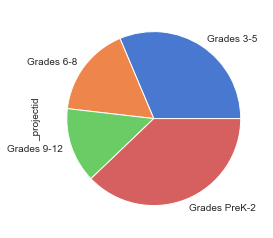

In [95]:
sns.set_style('white')
sns.set_palette('muted')
fig, ax = plt.subplots(1, 1)
ax.set_ylabel('')
projects_grade.plot(kind='pie', ax=ax)

Most of the fundings are demanded in elementary level, especially among lower grades. 

#### projects vs. poverty level

In [34]:
projects_pov = df_us.groupby('poverty_level')['_projectid'].nunique()

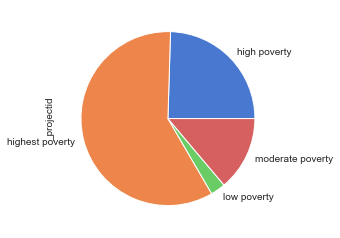

In [96]:
sns.set_style('white')
sns.set_palette('muted')
projects_pov.plot(kind='pie')

It makes sense that more donations are needed where the poverty level is high with limited government funding. 

#### focus area

With the current trends in tech development, schools are focusing more on technology-related education such as STEM. To see if the donation request match the trend, we will divide the projects into different subject areas.

In [ ]:
project_focus_area = df_us.groupby('primary_focus_area')['_projectid'].nunique().sort_values(ascending=False)

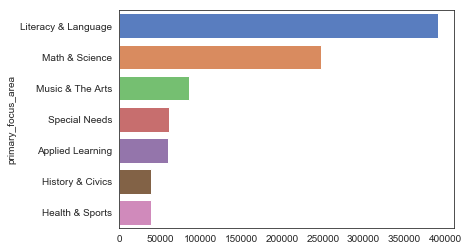

In [63]:
sns.set_palette('muted')
sns.barplot(x=project_focus_area.values, y=project_focus_area.index, order=project_focus_area.index)

Indeed, teachers are requesting more support in Literacy & Language and Math & Science categories. But was this the trend since the beginning? 

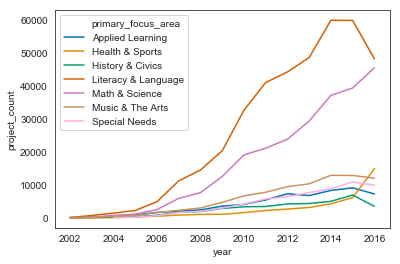

In [64]:
project_focus_area = df_us.groupby(['project_year','primary_focus_area'])['_projectid'].nunique()
project_focus_area = project_focus_area.to_frame().reset_index()
project_focus_area.columns = ['year', 'primary_focus_area', 'project_count']
sns.set_palette('colorblind')
sns.lineplot(data=project_focus_area, x='year', y='project_count', hue='primary_focus_area')

While all projects exhibit an upward trend, demand in Math & Science and Literacy & Language has grown exponentially. While most of the projects have started to slow down since 2015, projects in Math & Sicence continued to expand. Furthermore, I'm curious if the same pattern exists in all poverty levels. 

In [102]:
focus_poverty = df_us.groupby(['primary_focus_area', 'poverty_level'])['_projectid'].nunique()
focus_poverty = focus_poverty.to_frame().reset_index()
focus_poverty.head()

,primary_focus_area,poverty_level,_projectid
0,Applied Learning,high poverty,14880
1,Applied Learning,highest poverty,35671
2,Applied Learning,low poverty,1595
3,Applied Learning,moderate poverty,7892
4,Health & Sports,high poverty,9673


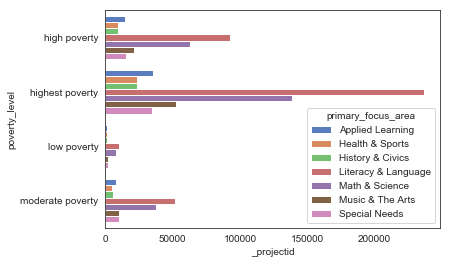

In [110]:
sns.barplot(x='_projectid', y='poverty_level', hue='primary_focus_area', data=focus_poverty)

Despite different wealth levels among schools, Literacy & Language and Math & Science are always on the top of the bucket list. 

### Teachers

The projects on the platform are teacher-driven. Let's first take a look at the total teacher population over years. 

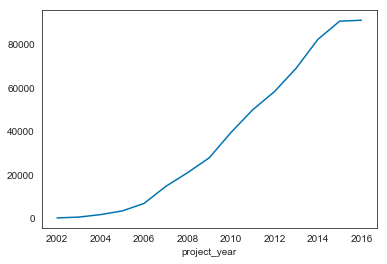

In [65]:
teacher_count = df_us.groupby('project_year')['_teacher_acctid'].nunique()
teacher_count
sns.set_style('white')
teacher_count.plot()

Teacher users have more than doubled from year 2010 to 2016. It exhibits a positive correlation with the project growth.  

Next, I would like to see how many projects are posted by female teachers vs. male teachers. 

In [66]:
df_us['teacher_gender'] = ['Female' if i in ['Mrs.', 'Ms.'] else 'Male' if i=='Mr.' else 'Unknown' for i in df_us['teacher_prefix']] 

C:\Users\Leo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [67]:
## number of teachers posting projects over years
teacher_over_time = df_us.groupby(['project_year', 'teacher_gender'])['_teacher_acctid'].nunique()
teacher_over_time = teacher_over_time.to_frame().reset_index()
teacher_over_time.columns = ['year', 'teacher_gender', 'teacher_count']
#teacher_over_time

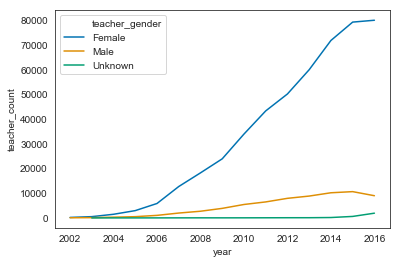

In [68]:
sns.lineplot(data=teacher_over_time, x='year', y='teacher_count', hue='teacher_gender')

We can spot that the number of male teachers grew very little and majority the projects are posted by female teachers. That's probably because female dominates the teaching industry.  

### Conclusion

With the above analysis, we can observe the following: 
* Out of the massive number of donors online, only 26% has donated more than once. 
* California and New York are the two states that hosted most of the donations. These are also the two states that have the biggest population.
* The project volume has grown rapidly in the past 10 years and the time to collect donation has decreased drastically. 
* Lower grades in elementary schools need the most financing support, especially in schools that are located in high-poverty regions. 
* Despite the poverty level, Literacy & Language and Math & Science are the categories that need the most funding. These two subjects have been more dominating in the recent years. 

Machine learning goals: 
* Identify the characteristics of the frequent donors and ways to motivate the others.